# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

# Importing and cleaning data

In [3]:
df_raw = pd.read_csv('Microsoft_Stock.csv')

In [4]:
df_raw.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [5]:
df = df_raw

In [6]:
df.info()
#data column is not datetime format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [7]:
#extracting important columns from dataframe
df  = df[['Date','Close','Volume']]
df.head()

,Date,Close,Volume
0,4/1/2015 16:00:00,40.72,36865322
1,4/2/2015 16:00:00,40.29,37487476
2,4/6/2015 16:00:00,41.55,39223692
3,4/7/2015 16:00:00,41.53,28809375
4,4/8/2015 16:00:00,41.42,24753438


In [8]:
df['Date'] = pd.to_datetime(df['Date']) #transform to datetime format

C:\Users\MAHMOU~1\AppData\Local\Temp/ipykernel_11520/759035642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']) #transform to datetime format


In [9]:
df['Date']= df['Date'].dt.date #extract only date part
df.info()
#again, date column is not datetime format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Close   1511 non-null   float64
 2   Volume  1511 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 35.5+ KB


C:\Users\MAHMOU~1\AppData\Local\Temp/ipykernel_11520/3645324426.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date']= df['Date'].dt.date #extract only date part


In [10]:
df['Date'] = pd.to_datetime(df['Date']) #transform to datetime format AGAIN
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1511 non-null   datetime64[ns]
 1   Close   1511 non-null   float64       
 2   Volume  1511 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 35.5 KB


C:\Users\MAHMOU~1\AppData\Local\Temp/ipykernel_11520/3503829629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date']) #transform to datetime format AGAIN


In [11]:
#indexing dataframe by date column
df.set_index('Date',inplace=True) 
df.head()

,Close,Volume
Date,,
2015-04-01,40.72,36865322
2015-04-02,40.29,37487476
2015-04-06,41.55,39223692
2015-04-07,41.53,28809375
2015-04-08,41.42,24753438


In [12]:
#applying frequency for index
df_freq = df.asfreq('D')

it seems that, some rows have missing data, let's plot the original data and data with (frequency-index)

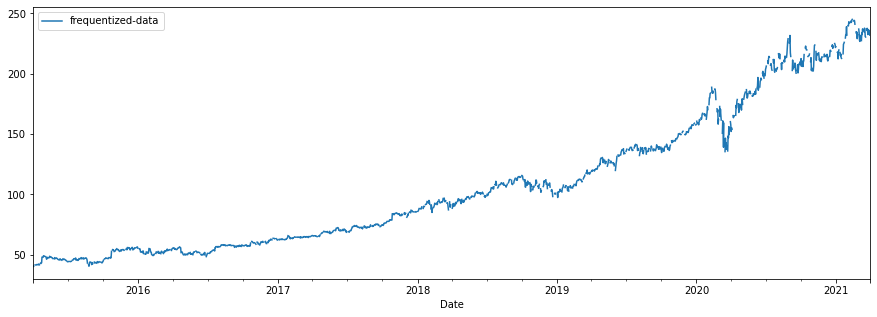

In [13]:
df_freq['Close'].plot(figsize=(15,5),label='frequentized-data',legend=True);

It's important to fill the null-data so that our model can work without errors

In [14]:
df_final = df_freq.fillna(method='ffill')

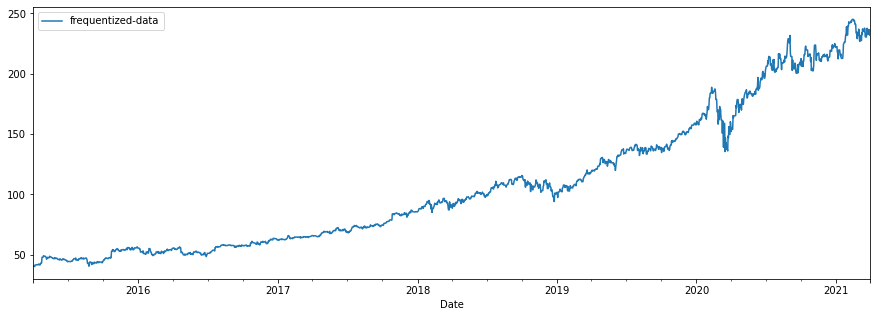

In [15]:
df_final['Close'].plot(figsize=(15,5),label='frequentized-data',legend=True);

In [16]:
df_final.head()

,Close,Volume
Date,,
2015-04-01,40.72,36865322.0
2015-04-02,40.29,37487476.0
2015-04-03,40.29,37487476.0
2015-04-04,40.29,37487476.0
2015-04-05,40.29,37487476.0


In [17]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2015-04-01 to 2021-03-31
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2192 non-null   float64
 1   Volume  2192 non-null   float64
dtypes: float64(2)
memory usage: 51.4 KB


# Visualizing data
Now, our data is clean and ready for analysis and modelling

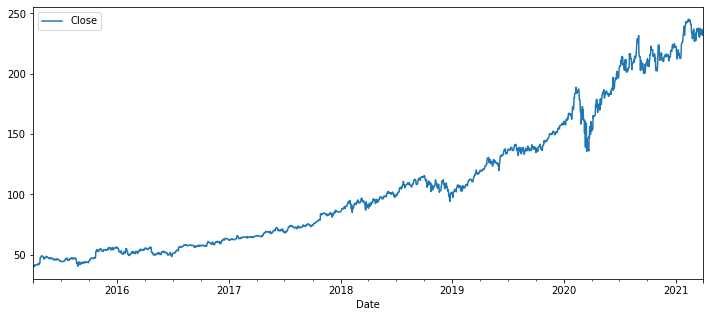

In [18]:
#basic plots
df_final['Close'].plot(figsize=(12,5),legend=True);

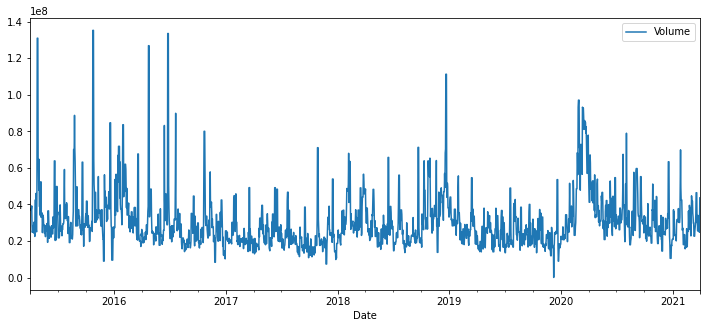

In [19]:
df_final['Volume'].plot(figsize=(12,5), legend=True);

Let's start with column (Close) by decomposing it, and check which model is best (mul or add), also which seasonal period is good

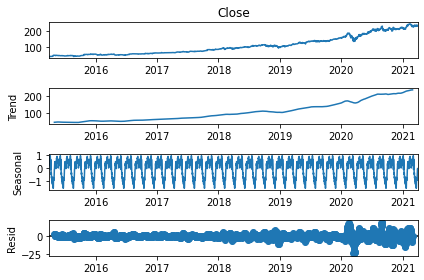

In [20]:
#decomposing time series
seasonal_decompose(df_final['Close'],model='add',period=60).plot();

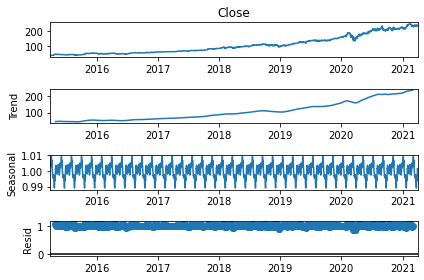

In [21]:
seasonal_decompose(df_final['Close'],model='mul',period=60).plot();

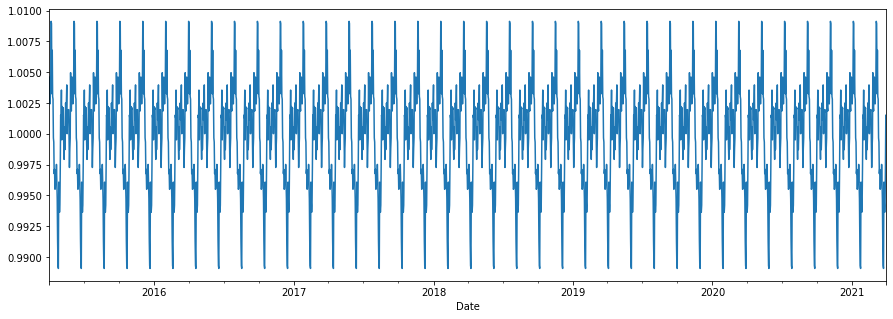

In [22]:
seasonal_decompose(df_final['Close'],model='mul',period=60).seasonal.plot(figsize=(15,5));

I think by looking at the residual component, multiplicative seasonality is good fit for modelling

**Findings:**
* data has a clear trend and seasonalilty (multiplicative approach) and 60 day seasonality

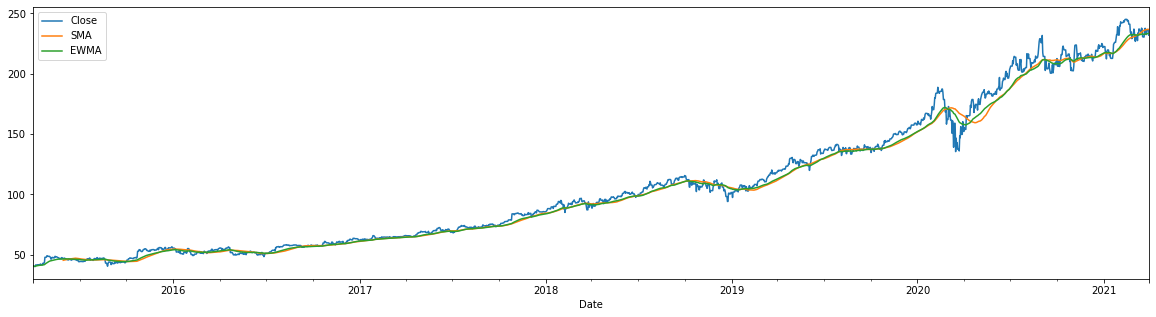

In [23]:
#plotting SMA60, EMA60
df_final['Close'].plot(figsize=(20,5),legend=True);
df_final['Close'].rolling(window=60).mean().plot(figsize=(20,5),label='SMA',legend=True)
df_final['Close'].ewm(span=60).mean().plot(figsize=(20,5),legend=True,label='EWMA');

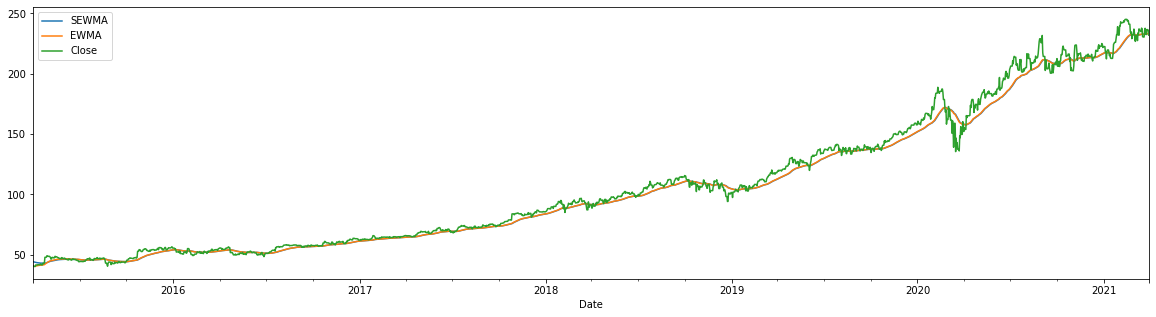

In [24]:
#Exponential weighted moving average is the same as (SimpleExponentialSmoothing)

span=60
alpha = 2/(1+span)
SimpleExpSmoothing(df_final['Close']).fit(smoothing_level=alpha).fittedvalues.plot(figsize=(20,5),legend=True,label='SEWMA');
df_final['Close'].ewm(span=60).mean().plot(figsize=(20,5),legend=True,label='EWMA');
df_final['Close'].plot(figsize=(20,5),legend=True);

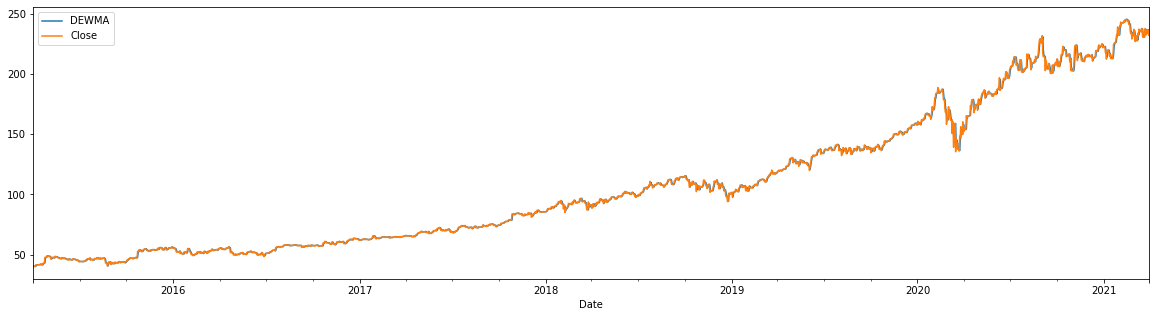

In [25]:
#interpreting trend component: Holt
ExponentialSmoothing(df_final['Close'],trend='mul').fit().fittedvalues.plot(figsize=(20,5),legend=True,label='DEWMA');
df_final['Close'].plot(figsize=(20,5),legend=True);

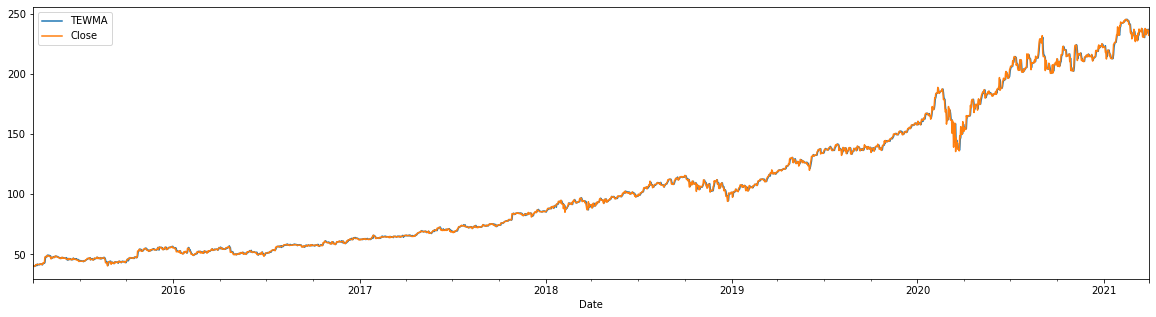

In [26]:
#interpretting seasonal & trend component: Holt Winters
#there is no-harmful error occurs when trend, seasonal are 'mul'
ExponentialSmoothing(df_final['Close'],trend='add',seasonal='add',seasonal_periods=60).fit().fittedvalues.plot(figsize=(20,5),legend=True,label='TEWMA');
df_final['Close'].plot(figsize=(20,5),legend=True);

# Modeling

## Finding best p,d,q orders

In [27]:
#test for stationarity
adfuller(df_final['Close'])[1]

0.9966392196370439

pval>0.05: data is not stationary

In [28]:
#check for differencing (1st difference)
adfuller(df_final['Close'].diff().dropna())[1]

1.0452175494178235e-17

pval<0.5: data (with first difference) is stationary

searching for orders (AR & MA) for full data

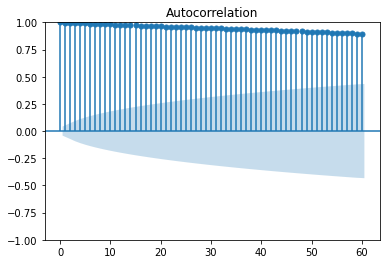

In [29]:
plot_acf(df_final['Close'],lags=60);

C:\Users\Mahmoud Shahwan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


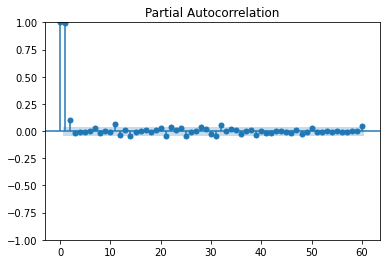

In [30]:
plot_pacf(df_final['Close'],lags=60);

searching for orders (AR & MA) for data (1st difference)

In [31]:
#finding the AR, MA orders but for the STATIONARY data for ARIMA model
df_diff = df_final.diff()
df_diff = df_diff.dropna()

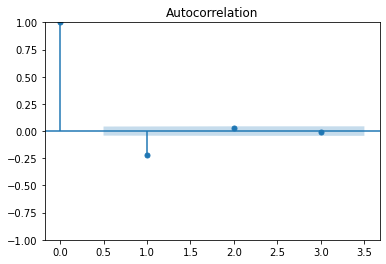

In [32]:
plot_acf(df_diff['Close'],lags=3);

MA order is 1

C:\Users\Mahmoud Shahwan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


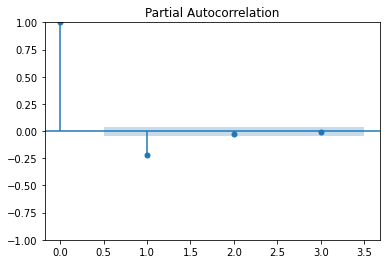

In [33]:
plot_pacf(df_diff['Close'],lags=3);

AR order is 1

## Splitting data

In [34]:
#data covers 2192 days
len(df_final)

2192

In [35]:
#we want to predict data for next 6 months (180 days)
len(df_final)*0.082
#test_size = .082

179.744

In [36]:
#splitting full data
tr_final,ts_final = train_test_split(df_final,test_size=.082,shuffle=False)

In [37]:
#splitting differenced data
tr_diff,ts_diff = train_test_split(df_diff,test_size=.082,shuffle=False)

## holt-winters model

In [38]:
model_hw = ExponentialSmoothing(tr_final['Close'],trend='mul',seasonal='mul',seasonal_periods=60).fit()

C:\Users\Mahmoud Shahwan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\Mahmoud Shahwan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [39]:
ypre_hw_final = model_hw.forecast(180)

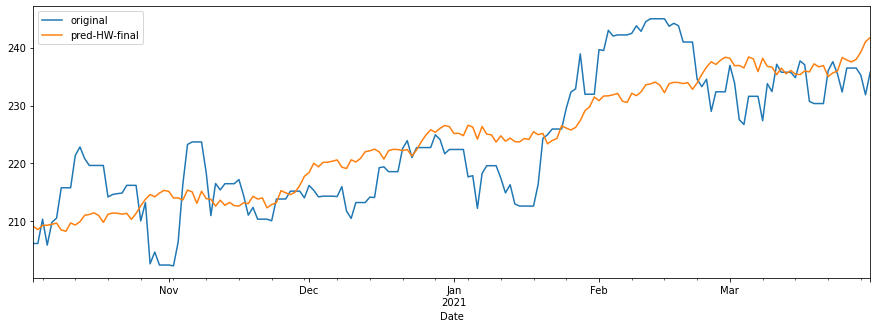

In [40]:
#plotting test & predicted results
ts_final['Close'].plot(figsize=(15,5),label='original',legend=True);
ypre_hw_final.plot(figsize=(15,5),label='pred-HW-final',legend=True);

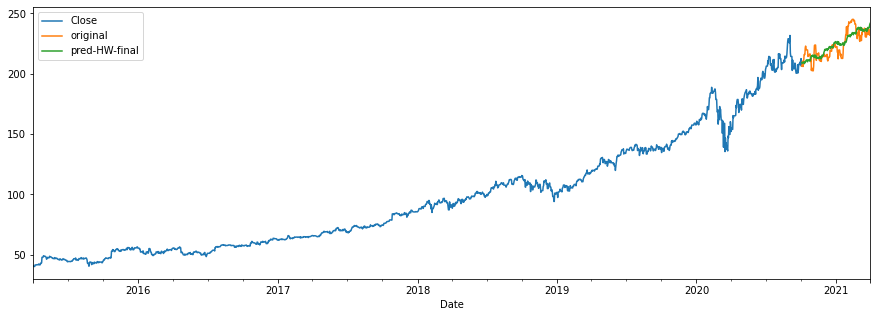

In [41]:
#plotting the whole data
tr_final['Close'].plot(figsize=(15,5),legend=True);
ts_final['Close'].plot(figsize=(15,5),label='original',legend=True);
ypre_hw_final.plot(figsize=(15,5),label='pred-HW-final',legend=True);

In [42]:
#testing the error
x = ts_final['Close'].mean()
y = np.sqrt(mean_squared_error(ts_final['Close'],ypre_hw_final)) 
error = y/x
error

0.029967540614161844

we can play with seasonal_periods, any other paramters to overfit our model

## ARIMA model - original data

previously, we've selected orders (1,1,1) for ARIMA model


In [43]:
model_arima = ARIMA(tr_final['Close'],order=(1,1,1)).fit()

In [44]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2012
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4018.601
Date:                Sat, 07 Jan 2023   AIC                           8043.202
Time:                        10:31:15   BIC                           8060.022
Sample:                    04-01-2015   HQIC                          8049.376
                         - 10-02-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0919      0.043     -2.151      0.031      -0.176      -0.008
ma.L1         -0.1725      0.043     -4.013      0.000      -0.257      -0.088
sigma2         3.1858      0.028    114.831      0.000       3.131       3.240
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             81121.19
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):              17.98   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
tr_final.tail(1)

,Close,Volume
Date,,
2020-10-02,206.19,33154781.0


In [46]:
ts_final.tail(1)

,Close,Volume
Date,,
2021-03-31,235.77,43623471.0


In [47]:
start = "2020-10-02"
end = '2021-03-31'
ypre_arima_final = model_arima.predict(start=start,end=end,typ='levels',dynamic=True)

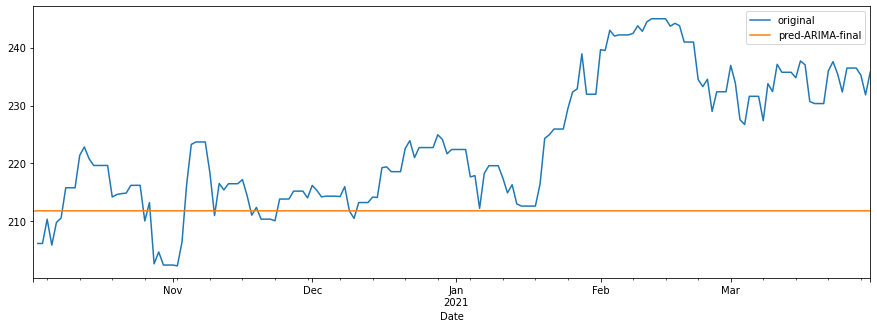

In [48]:
#plotting test & predicted results
ts_final['Close'].plot(figsize=(15,5),label='original',legend=True);
ypre_arima_final.plot(figsize=(15,5),label='pred-ARIMA-final',legend=True);

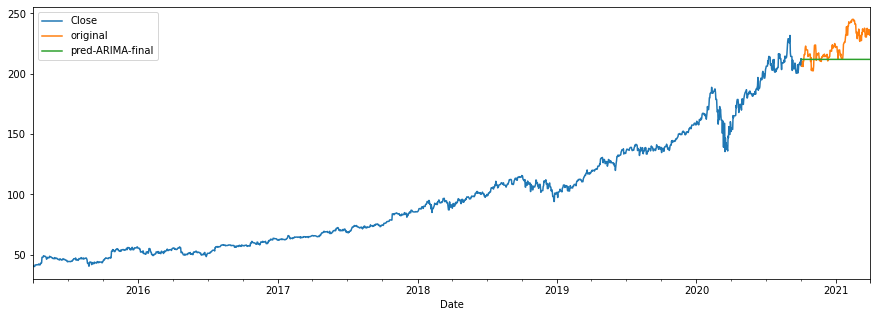

In [49]:
#plotting the whole data
tr_final['Close'].plot(figsize=(15,5),legend=True);
ts_final['Close'].plot(figsize=(15,5),label='original',legend=True);
ypre_arima_final.plot(figsize=(15,5),label='pred-ARIMA-final',legend=True);

## changing ARIMA orders
changing difference order to be 2

In [50]:
model_arima = ARIMA(tr_final['Close'],order=(1,2,1)).fit()

In [51]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2012
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -4019.851
Date:                Sat, 07 Jan 2023   AIC                           8045.702
Time:                        10:31:17   BIC                           8062.519
Sample:                    04-01-2015   HQIC                          8051.875
                         - 10-02-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2552      0.008    -31.314      0.000      -0.271      -0.239
ma.L1         -0.9990      0.001   -725.253      0.000      -1.002      -0.996
sigma2         3.1855      0.026    123.116      0.000       3.135       3.236
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):             85230.02
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):              18.10   Skew:                            -1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
tr_final.tail(1)

,Close,Volume
Date,,
2020-10-02,206.19,33154781.0


In [53]:
ts_final.tail(1)

,Close,Volume
Date,,
2021-03-31,235.77,43623471.0


In [54]:
start = "2020-10-02"
end = '2021-03-31'
ypre_arima_final = model_arima.predict(start=start,end=end,typ='levels',dynamic=True)

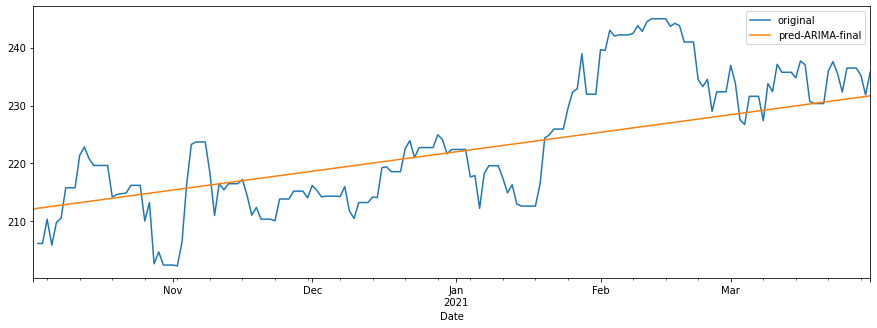

In [55]:
#plotting test & predicted results
ts_final['Close'].plot(figsize=(15,5),label='original',legend=True);
ypre_arima_final.plot(figsize=(15,5),label='pred-ARIMA-final',legend=True);

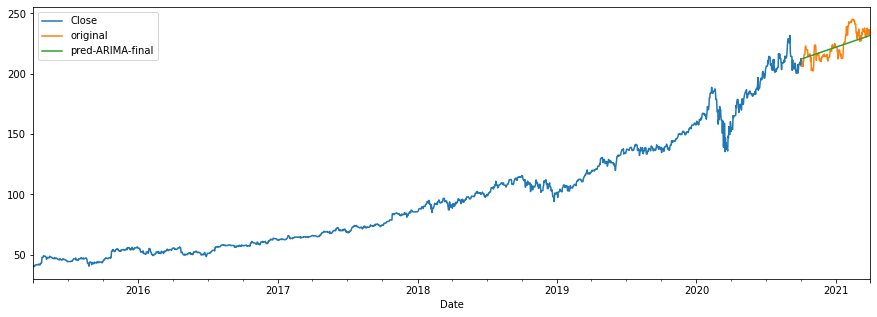

In [56]:
#plotting the whole data
tr_final['Close'].plot(figsize=(15,5),legend=True);
ts_final['Close'].plot(figsize=(15,5),label='original',legend=True);
ypre_arima_final.plot(figsize=(15,5),label='pred-ARIMA-final',legend=True);

## ARIMA model - differenced data

In [57]:
model_arima_diff = ARIMA(tr_diff['Close'],order=(1,1,1)).fit()

In [58]:
tr_final.tail(1)

,Close,Volume
Date,,
2020-10-02,206.19,33154781.0


In [59]:
ts_final.tail(1)

,Close,Volume
Date,,
2021-03-31,235.77,43623471.0


In [60]:
start = "2020-10-02"
end = '2021-03-31'
ypre_arima_diff = model_arima_diff.predict(start=start,end=end)

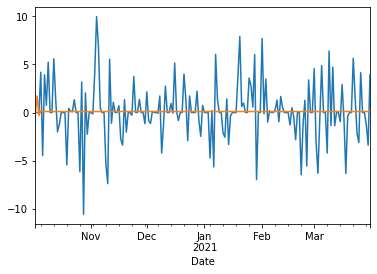

In [61]:
#plotting results
ts_diff['Close'].plot();
ypre_arima_diff.plot();

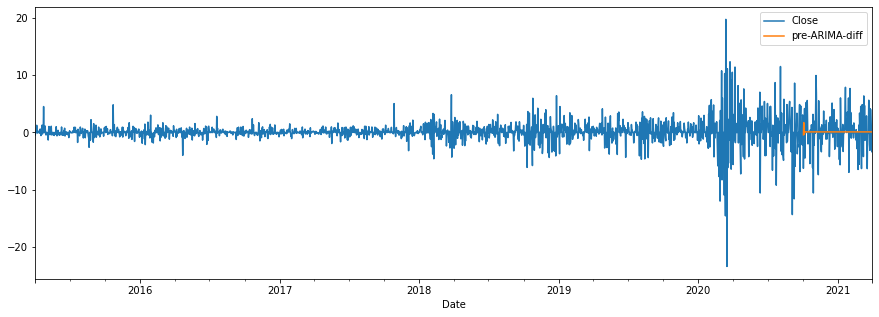

In [62]:
#plotting the whole data (1st difference)
df_diff['Close'].plot(figsize=(15,5),legend=True);
ypre_arima_diff.plot(figsize=(15,5),legend=True,label='pre-ARIMA-diff');

In [63]:
#getting result of first and last row in train_difference, to add it to differenced values of (test&predicted) data
head = tr_final['Close'].head(1)[0]
tail = tr_diff['Close'].cumsum().tail(1)[0]
print (head)
print (tail)
add_val = head+tail

40.72
165.47


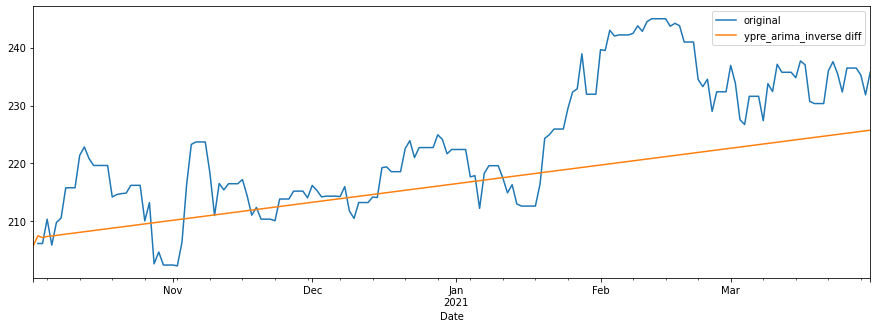

In [64]:
#plotting results after inverse difference
(ts_diff['Close'].cumsum()+add_val).plot(figsize=(15,5), legend=True,label='original');
(ypre_arima_diff.cumsum()+add_val).plot(figsize=(15,5), legend=True,label='ypre_arima_inverse diff');

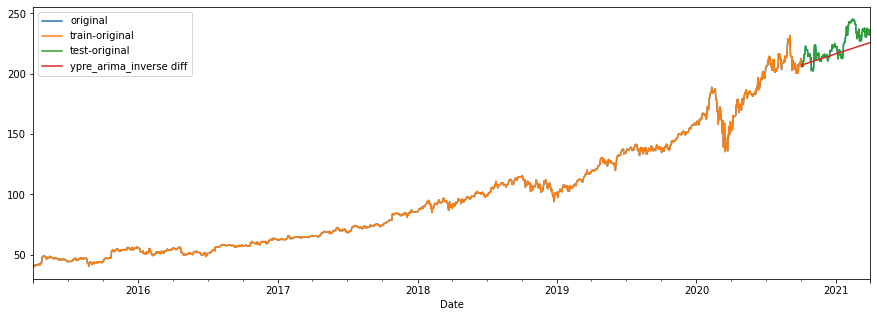

In [65]:
#plotting the whole data after inverse difference

df_final['Close'].plot(figsize=(15,5), legend=True,label='original');
#add only the head
(tr_diff['Close'].cumsum()+head).plot(figsize=(15,5), legend=True,label='train-original');

#add add_val(head+tail)
(ts_diff['Close'].cumsum()+add_val).plot(figsize=(15,5), legend=True,label='test-original');
(ypre_arima_diff.cumsum()+add_val).plot(figsize=(15,5), legend=True,label='ypre_arima_inverse diff');

## SARIMA model - original data

**important: I'm not able to fit SARIMA model yet, so feel free to add your knowledge to my code**

In [66]:
auto_arima(tr_final['Close'],trace=False,m=12)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [67]:
auto_arima(tr_final['Close'],trace=True,m=12,test='adf',start_p=1,d=1,start_q=1)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=8029.508, Time=2.50 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8173.578, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8039.067, Time=0.72 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8034.323, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8175.575, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=8035.892, Time=1.33 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=8035.211, Time=0.95 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=8023.981, Time=5.12 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=8021.994, Time=2.87 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=8021.001, Time=1.50 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=8033.574, Time=0.50 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=8022.994, Time=3.48 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=8027.928, Time=1.72 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=8147.827, Time=1.43 sec
 ARIMA(0,1,2)(2,0,0

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [68]:
auto_arima(tr_final['Close'],trace=True,m=12,test='adf')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=8032.838, Time=4.95 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=8173.578, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=8039.067, Time=0.55 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=8034.323, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=8175.575, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=8039.181, Time=4.37 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=8038.503, Time=4.57 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=8026.947, Time=17.72 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=8024.976, Time=18.50 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=8023.206, Time=16.65 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=8037.490, Time=3.38 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=8025.379, Time=18.72 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=8031.777, Time=3.87 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=8021.852, Time=1.99 sec
 ARIMA(0,1,2)(1

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

In [69]:
model_sarima = SARIMAX(tr_final['Close'],order=(0, 1, 1),seasonal_order=(2, 0, 0, 12)).fit()

In [70]:
model_sarima = SARIMAX(tr_final['Close'],order=(3, 1, 2),seasonal_order=(2, 1, 0, 12)).fit()

C:\Users\Mahmoud Shahwan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Mahmoud Shahwan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Mahmoud Shahwan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
ypre_sarima_final = model_sarima.predict(start=start,end=end)

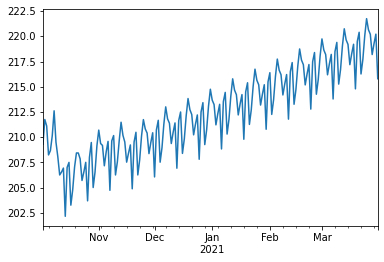

In [72]:
ypre_sarima_final.plot();

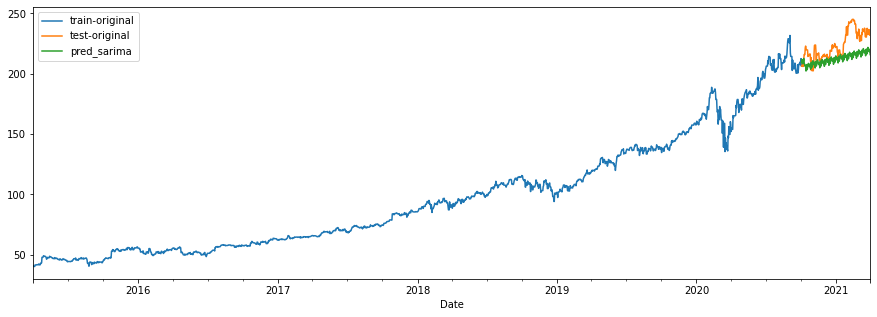

In [73]:
tr_final['Close'].plot(figsize=(15,5), legend=True,label='train-original')
ts_final['Close'].plot(figsize=(15,5), legend=True,label='test-original')
ypre_sarima_final.plot(figsize=(15,5), legend=True,label='pred_sarima');

In [ ]:
auto_arima(tr_final['Close'],trace=True,m=6)

Performing stepwise search to minimize aic


In [ ]:
auto_arima(tr_final['Close'],m=6).summary()

In [ ]:
model_sarima = SARIMAX(tr_final['Close'],order=(0,1,1),seasonal_order=(2,0,0,6)).fit()

In [ ]:
ypre_sarima_final = model_sarima.predict(start=start,end=end)
ypre_sarima_final

In [ ]:
#plotting results
ts_final['Close'].plot(figsize=(15,5),label='original',legend=True);
ypre_sarima_final.plot(figsize=(15,5),label='pred-sarima-final',legend=True);

In [ ]:
head = tr_diff['Close'].head(1)[0]
tail = tr_diff['Close'].tail(1)[0]
add_val = head+tail

In [ ]:
#plotting results
tr_final['Close'].plot(figsize=(15,5),legend=True,label='original');
ts_final['Close'].plot(figsize=(15,5),legend=True,label='original');
ypre_sarima_final.plot(figsize=(15,5),legend=True,label='original');